In [74]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/oral-cancer-prediction-dataset/oral_cancer_prediction_dataset.csv


## **1. Introduction**

**Problem Statement**

Oral cancer is a significant global health concern, particularly in regions with high incidence rates such as India, Pakistan, Sri Lanka, and Taiwan. It is often diagnosed at later stages, leading to high mortality rates and increased treatment costs. Key risk factors include tobacco use, alcohol consumption, HPV infection, poor oral hygiene, and dietary habits. Early detection is crucial in improving survival rates and reducing the economic burden on patients.

**Project Objective** 

The goal of this project is to develop a predictive model for oral cancer diagnosis based on key risk factors, symptoms, and socio-economic variables. By leveraging machine learning techniques, we aim to:

- Analyze and preprocess the dataset to handle missing values, outliers, and imbalanced classes.
- Perform exploratory data analysis (EDA) to identify trends and correlations among risk factors.
- Develop and evaluate predictive models to classify whether an individual is diagnosed with oral cancer or not.
- Assess feature importance to determine the most influential factors contributing to oral cancer.
- Provide insights and recommendations for early detection and prevention strategies.
- 
By the end of this project, we will have a data-driven approach to identifying high-risk individuals, potentially aiding medical professionals and policymakers in early diagnosis and preventive care.

## 2. **Importing Libraries**

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [76]:
# load the data set
df = pd.read_csv('/kaggle/input/oral-cancer-prediction-dataset/oral_cancer_prediction_dataset.csv')
df.head()

,ID,Country,Age,Gender,Tobacco Use,Alcohol Consumption,HPV Infection,Betel Quid Use,Chronic Sun Exposure,Poor Oral Hygiene,...,Difficulty Swallowing,White or Red Patches in Mouth,Tumor Size (cm),Cancer Stage,Treatment Type,"Survival Rate (5-Year, %)",Cost of Treatment (USD),Economic Burden (Lost Workdays per Year),Early Diagnosis,Oral Cancer (Diagnosis)
0,1,Italy,36,Female,Yes,Yes,Yes,No,No,Yes,...,No,No,0.000000,0,No Treatment,100.000000,0.00,0,No,No
1,2,Japan,64,Male,Yes,Yes,Yes,No,Yes,Yes,...,No,No,1.782186,1,No Treatment,83.340103,77772.50,177,No,Yes
2,3,UK,37,Female,No,Yes,No,No,Yes,Yes,...,No,Yes,3.523895,2,Surgery,63.222871,101164.50,130,Yes,Yes
3,4,Sri Lanka,55,Male,Yes,Yes,No,Yes,No,Yes,...,No,No,0.000000,0,No Treatment,100.000000,0.00,0,Yes,No
4,5,South Africa,68,Male,No,No,No,No,No,Yes,...,No,No,2.834789,3,No Treatment,44.293199,45354.75,52,No,Yes


## **3. Data Cleaning**

In [77]:
# check basic info to see column dtypes and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84922 entries, 0 to 84921
Data columns (total 25 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   ID                                        84922 non-null  int64  
 1   Country                                   84922 non-null  object 
 2   Age                                       84922 non-null  int64  
 3   Gender                                    84922 non-null  object 
 4   Tobacco Use                               84922 non-null  object 
 5   Alcohol Consumption                       84922 non-null  object 
 6   HPV Infection                             84922 non-null  object 
 7   Betel Quid Use                            84922 non-null  object 
 8   Chronic Sun Exposure                      84922 non-null  object 
 9   Poor Oral Hygiene                         84922 non-null  object 
 10  Diet (Fruits & Vegetables Intake) 

In [78]:
# check the shape to get an idea of how large the dataset is
df.shape

(84922, 25)

In [79]:
# check for missing values 
df.isnull().sum()

ID                                          0
Country                                     0
Age                                         0
Gender                                      0
Tobacco Use                                 0
Alcohol Consumption                         0
HPV Infection                               0
Betel Quid Use                              0
Chronic Sun Exposure                        0
Poor Oral Hygiene                           0
Diet (Fruits & Vegetables Intake)           0
Family History of Cancer                    0
Compromised Immune System                   0
Oral Lesions                                0
Unexplained Bleeding                        0
Difficulty Swallowing                       0
White or Red Patches in Mouth               0
Tumor Size (cm)                             0
Cancer Stage                                0
Treatment Type                              0
Survival Rate (5-Year, %)                   0
Cost of Treatment (USD)           

In [80]:
# check for duplicated values 
df.duplicated().sum()

0

#### **Observations from Data Inspection**

✅ No Missing or Duplicated Values – This is great because we don’t need to handle missing data!
✅ Shape of Data – The dataset contains 84,922 rows and 25 columns, meaning it's quite large and detailed.
✅ Data Types –

- Numerical Columns: Age, Tumor Size, Cancer Stage, Survival Rate, Cost of Treatment, Economic Burden.
- Categorical Columns: Most columns (Tobacco Use, Alcohol Consumption, HPV Infection, etc.) are binary (Yes/No) or multi-class (e.g., Diet, Treatment Type).

## 4. EDA

Now, we’ll explore and visualize the dataset to understand:
- Target Variable Distribution (Oral Cancer Diagnosis)
- Feature Distributions (Age, Tumor Size, etc.)
- Categorical Variables (Risk factors, Symptoms, etc.)
- Correlations & Relationships (between different features)

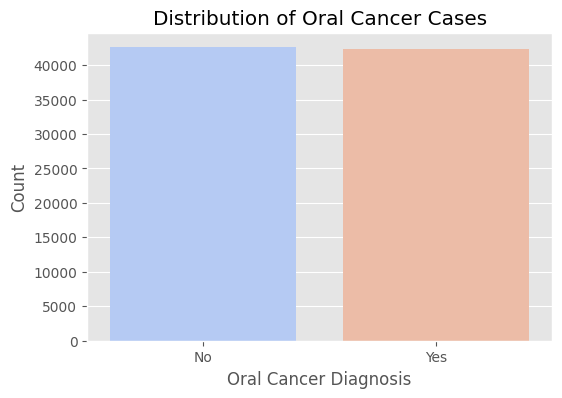

In [81]:
# we check the distribution of the target variable
# Set plot style
plt.style.use("ggplot")

# Plot distribution of target variable
plt.figure(figsize=(6, 4))
sns.countplot(x=df["Oral Cancer (Diagnosis)"], palette="coolwarm")

# Add labels and title
plt.xlabel("Oral Cancer Diagnosis")
plt.ylabel("Count")
plt.title("Distribution of Oral Cancer Cases")
plt.show()

Since the target variable is balanced, let's move on to visualizing some key numerical features to understand their distributions. We'll use histograms and boxplots to check for skewness and outliers.

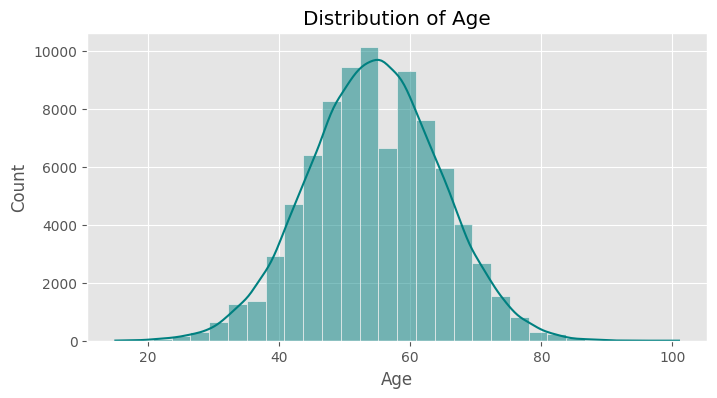

In [82]:
# age distribution
plt.figure(figsize=(8, 4))
sns.histplot(df["Age"], bins=30, kde=True, color="teal")
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Distribution of Age")
plt.show()

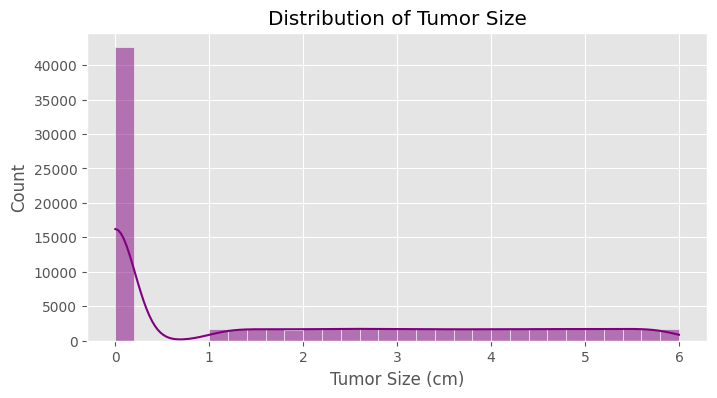

In [83]:
# tumor size distribution
plt.figure(figsize=(8, 4))
sns.histplot(df["Tumor Size (cm)"], bins=30, kde=True, color="purple")
plt.xlabel("Tumor Size (cm)")
plt.ylabel("Count")
plt.title("Distribution of Tumor Size")
plt.show()

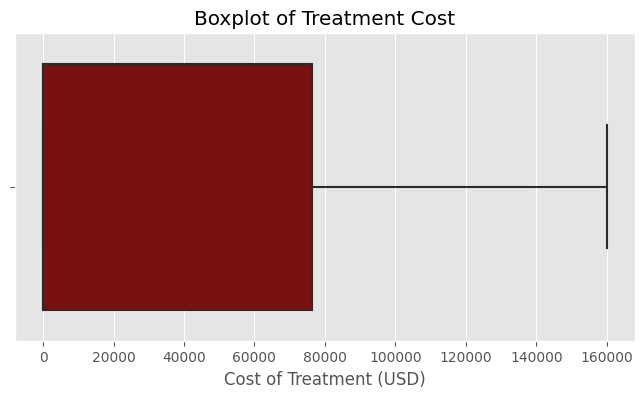

In [84]:
# boxplot of cost treatment
plt.figure(figsize=(8, 4))
sns.boxplot(x=df["Cost of Treatment (USD)"], color="darkred")
plt.xlabel("Cost of Treatment (USD)")
plt.title("Boxplot of Treatment Cost")
plt.show()

#### **Analysis of Distributions**

**1️⃣ Age Distribution:**
The age distribution is approximately normal, meaning that oral cancer cases are spread evenly across different age groups, with most cases concentrated around the mean age. This suggests that oral cancer is not heavily skewed toward only younger or older individuals but affects a broad age range.

**2️⃣ Tumor Size Distribution:**
The majority of tumor sizes are clustered around 0 cm, with over 40,000 cases in this range, while the rest are much lower (below 5,000). This could indicate a significant number of cases where no detectable tumor was recorded—possibly early-stage diagnoses or cases where lesions were present but not classified as tumors. This warrants further investigation into the Early Diagnosis feature.

**3️⃣ Cost of Treatment:**
The boxplot of treatment costs shows no significant outliers, meaning that treatment expenses are relatively consistent across different cases. This suggests that costs are well-distributed without extreme variations, which is useful for financial planning and assessing economic burdens in different regions.

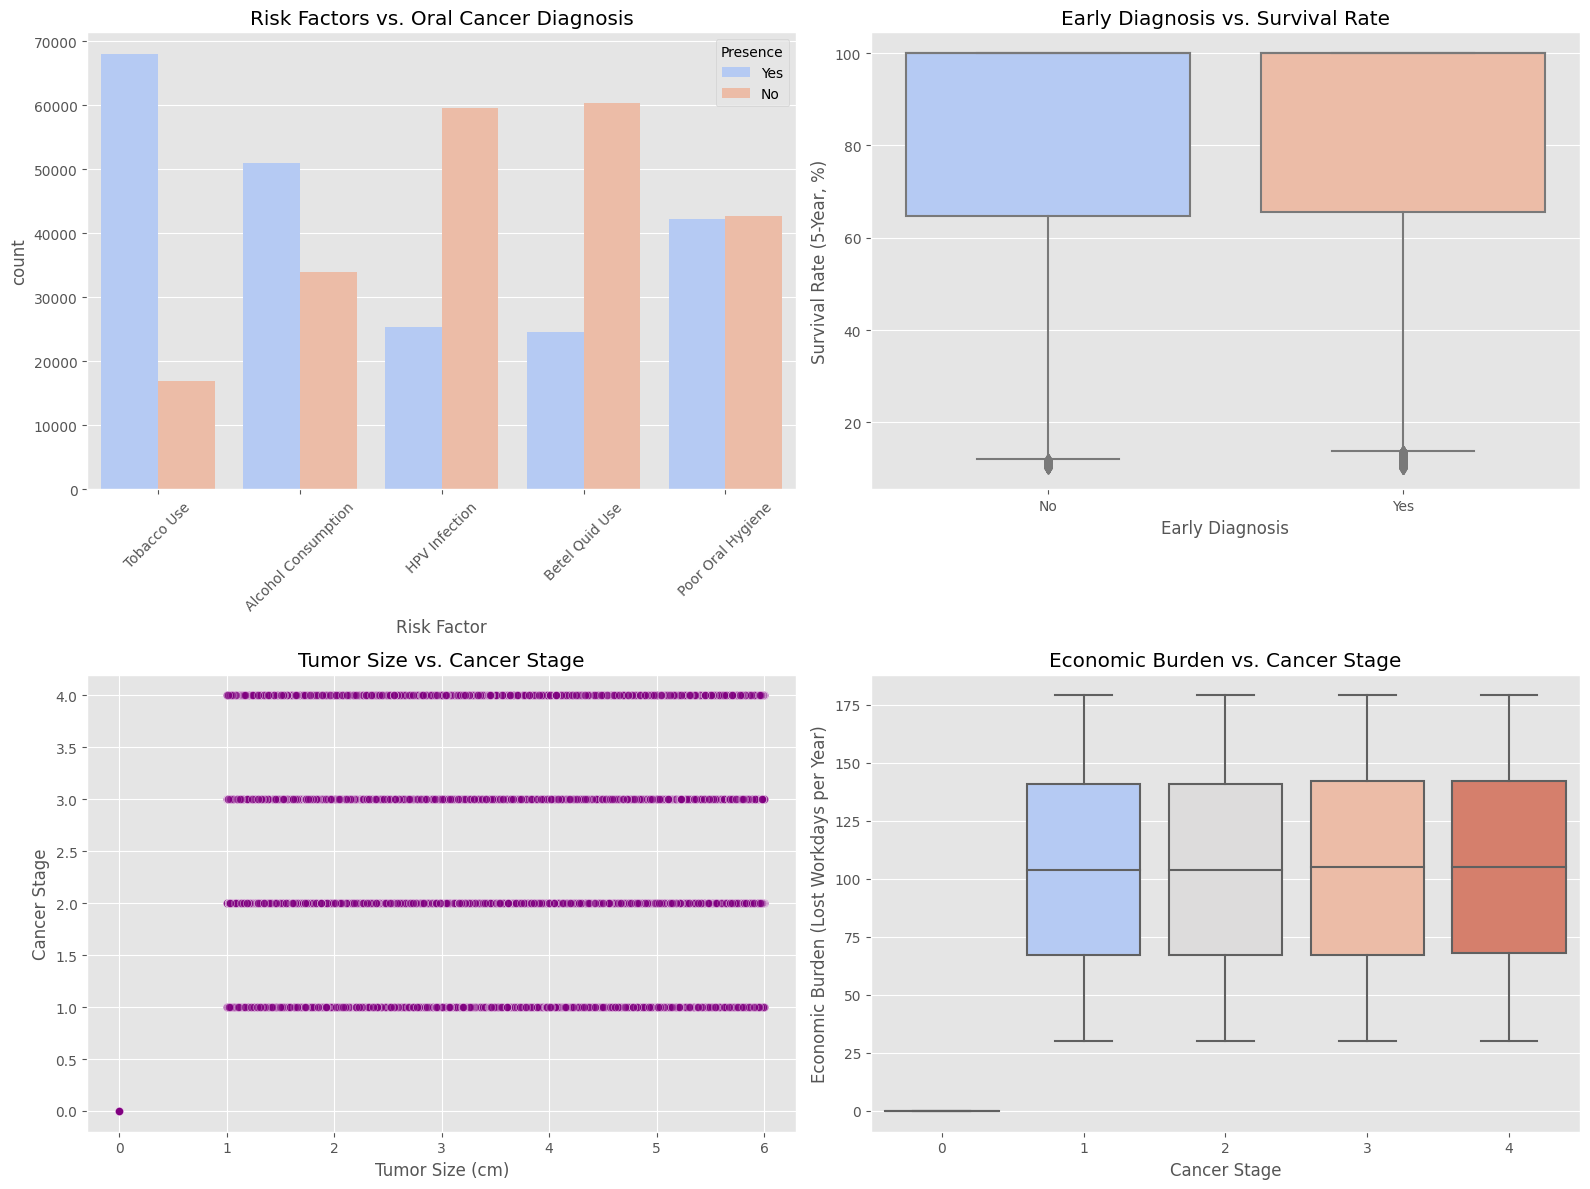

In [85]:
plt.figure(figsize=(16, 12))

# 1️⃣ Risk Factors vs. Oral Cancer Diagnosis
plt.subplot(2, 2, 1)
risk_factors = ["Tobacco Use", "Alcohol Consumption", "HPV Infection", "Betel Quid Use", "Poor Oral Hygiene"]
df_melted = df.melt(id_vars="Oral Cancer (Diagnosis)", value_vars=risk_factors, var_name="Risk Factor", value_name="Presence")
sns.countplot(data=df_melted, x="Risk Factor", hue="Presence", palette="coolwarm")
plt.xticks(rotation=45)
plt.title("Risk Factors vs. Oral Cancer Diagnosis")

# 2️⃣ Early Diagnosis vs. Survival Rate
plt.subplot(2, 2, 2)
sns.boxplot(data=df, x="Early Diagnosis", y="Survival Rate (5-Year, %)", palette="coolwarm")
plt.title("Early Diagnosis vs. Survival Rate")

# 3️⃣ Tumor Size vs. Cancer Stage
plt.subplot(2, 2, 3)
sns.scatterplot(data=df, x="Tumor Size (cm)", y="Cancer Stage", alpha=0.5, color="purple")
plt.title("Tumor Size vs. Cancer Stage")

# 4️⃣ Economic Burden vs. Cancer Stage
plt.subplot(2, 2, 4)
sns.boxplot(data=df, x="Cancer Stage", y="Economic Burden (Lost Workdays per Year)", palette="coolwarm")
plt.title("Economic Burden vs. Cancer Stage")

plt.tight_layout()
plt.show()

## 5. Feature Engineering

Here are some new features that might work better with the models later

**1. Creating a Risk Score Feature**

We can create a risk score by assigning points to risk factors like tobacco use, alcohol consumption, HPV infection, betel quid use, and poor oral hygiene. A simple scoring system could be:

- +1 for each "Yes" in these risk factors.
- Sum up these values into a new "Risk Score" feature.

**2. Categorizing Tumor Size**

Instead of using tumor size as a continuous variable, we can categorize it into bins:

- Small (≤2 cm)
- Medium (2–4 cm)
- Large (>4 cm)
This will help in understanding severity better.

**3. Economic Burden Index**

We can create a new feature that represents how much of a financial burden the treatment is. This will help understand affordability challenges.

**4. Age Groups**

Instead of using raw age values, we can group them into:

- Young (≤30 years)
- Middle-aged (31-60 years)
- Elderly (>60 years)
  
**5. Survival Rate Categorization**
   
We can create a categorical variable based on survival rate:

- High Survival (>70%)
- Moderate Survival (40-70%)
- Low Survival (<40%)


In [86]:
df_new = df.copy()

# 1. Creating a Risk Score Feature
df_new["Risk Score"] = (
    (df_new["Tobacco Use"] == "Yes").astype(int) +
    (df_new["Alcohol Consumption"] == "Yes").astype(int) +
    (df_new["HPV Infection"] == "Yes").astype(int) +
    (df_new["Betel Quid Use"] == "Yes").astype(int) +
    (df_new["Poor Oral Hygiene"] == "Yes").astype(int)
)

In [87]:
# 2. Categorizing Tumor Size
def categorize_tumor(size):
    if size <= 2:
        return "Small"
    elif 2 < size <= 4:
        return "Medium"
    else:
        return "Large"

df_new["Tumor Size Category"] = df_new["Tumor Size (cm)"].apply(categorize_tumor)

In [88]:
# 3. Economic Burden Index
df_new["Economic Burden Index"] = df_new["Cost of Treatment (USD)"] / (df_new["Economic Burden (Lost Workdays per Year)"] + 1)

In [89]:
# 4. Age Groups
def categorize_age(age):
    if age <= 30:
        return "Young"
    elif 31 <= age <= 60:
        return "Middle-aged"
    else:
        return "Elderly"

df_new["Age Group"] = df_new["Age"].apply(categorize_age)

In [90]:
# 5. Survival Rate Categorization
def categorize_survival(rate):
    if rate > 70:
        return "High Survival"
    elif 40 <= rate <= 70:
        return "Moderate Survival"
    else:
        return "Low Survival"

df_new["Survival Rate Category"] = df_new["Survival Rate (5-Year, %)"].apply(categorize_survival)

In [91]:
# Display the first few rows to check the new features
df_new.head()

,ID,Country,Age,Gender,Tobacco Use,Alcohol Consumption,HPV Infection,Betel Quid Use,Chronic Sun Exposure,Poor Oral Hygiene,...,"Survival Rate (5-Year, %)",Cost of Treatment (USD),Economic Burden (Lost Workdays per Year),Early Diagnosis,Oral Cancer (Diagnosis),Risk Score,Tumor Size Category,Economic Burden Index,Age Group,Survival Rate Category
0,1,Italy,36,Female,Yes,Yes,Yes,No,No,Yes,...,100.000000,0.00,0,No,No,4,Small,0.000000,Middle-aged,High Survival
1,2,Japan,64,Male,Yes,Yes,Yes,No,Yes,Yes,...,83.340103,77772.50,177,No,Yes,4,Small,436.924157,Elderly,High Survival
2,3,UK,37,Female,No,Yes,No,No,Yes,Yes,...,63.222871,101164.50,130,Yes,Yes,2,Medium,772.248092,Middle-aged,Moderate Survival
3,4,Sri Lanka,55,Male,Yes,Yes,No,Yes,No,Yes,...,100.000000,0.00,0,Yes,No,4,Small,0.000000,Middle-aged,High Survival
4,5,South Africa,68,Male,No,No,No,No,No,Yes,...,44.293199,45354.75,52,No,Yes,1,Medium,855.750000,Elderly,Moderate Survival


next steps: Model selection and training